# Notes about Normalization and Beams

In [59]:
# ipython notebook setup:
%matplotlib inline

In [60]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'

In [61]:
from astropy import convolution
import numpy as np

In [62]:
shape = [256,256]

ygrid, xgrid = np.indices(shape, dtype='float')
rr = ((xgrid-shape[1]/2)**2+(ygrid-shape[0]/2)**2)**0.5

largest_scale = 56.
smallest_scale = 2.5
image_scale = shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

lowresfwhm = 40

singledish_kernel = convolution.Gaussian2DKernel(lowresfwhm/2.35, x_size=shape[1], y_size=shape[0])
singledish_kernel_fft = np.fft.fft2(singledish_kernel)

The "ring" and the single dish kernel represent the approximate weights of your input data when feathering.

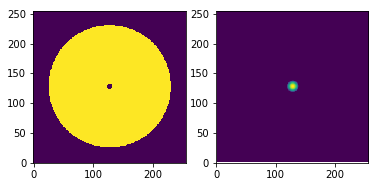

In [63]:
pl.subplot(1,2,1)
pl.imshow(ring)
pl.subplot(1,2,2)
pl.imshow(np.fft.fftshift(np.abs(singledish_kernel_fft)), cmap='viridis',
          norm=pl.matplotlib.colors.LogNorm(),
          vmin=1e-4,
         )

Add the weights together (where we're treating both weights as peak-normalized).

In [64]:
total_weight_psf = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(np.abs(singledish_kernel_fft)) + ring)))
print(total_weight_psf.sum(), total_weight_psf.max())
total_weight_psf /= total_weight_psf.max() # the PSF is peak-normalized

1356432.32804 32904.0011028


The FFT of the sum of the weights is the PSF.

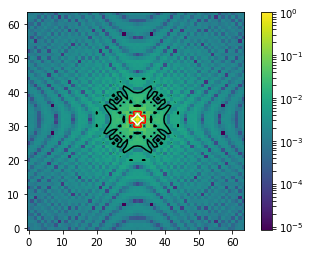

In [65]:
zoom_region = 32
pl.imshow(total_weight_psf[int(shape[0]/2-zoom_region):int(shape[0]/2+zoom_region),
                           int(shape[1]/2-zoom_region):int(shape[1]/2+zoom_region)],
          norm=pl.matplotlib.colors.LogNorm(),)
pl.colorbar()
pl.contour(total_weight_psf[int(shape[0]/2-zoom_region):int(shape[0]/2+zoom_region),
                           int(shape[1]/2-zoom_region):int(shape[1]/2+zoom_region)],
           colors=['k','r','w'], levels=[0.01,0.1,0.2])

This is another approach where the *PSF* is peak normalized and the `weights=FT(PSF)` are sum-normalized.  It heavily favors the single dish data.

In [66]:
total_weight_psf = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(np.abs(singledish_kernel_fft) /
                                                                      np.abs(singledish_kernel_fft).sum())
                                                      + ring/ring.sum())))
print(total_weight_psf.sum(), total_weight_psf.max())
total_weight_psf /= total_weight_psf.max() # the PSF is peak-normalized

1835.96066336 2.0


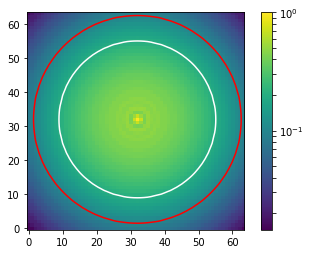

In [67]:
zoom_region = 32
pl.imshow(total_weight_psf[int(shape[0]/2-zoom_region):int(shape[0]/2+zoom_region),
                           int(shape[1]/2-zoom_region):int(shape[1]/2+zoom_region)],
          norm=pl.matplotlib.colors.LogNorm(),)
pl.colorbar()
pl.contour(total_weight_psf[int(shape[0]/2-zoom_region):int(shape[0]/2+zoom_region),
                            int(shape[1]/2-zoom_region):int(shape[1]/2+zoom_region)],
           colors=['k','r','w'], levels=[0.01,0.1,0.2])

# Examples using different weighting schemes

In [68]:
from uvcombine.tests import utils
from uvcombine import feather_simple
from astropy import units as u
from astropy.io import fits
from astropy import log

This is just normal 'feathering' with LAS = 100" and SD resolution 33"

In [69]:
pixel_scale = 1*u.arcsec
log.info("Generate input image")
input_hdu = utils.generate_test_fits(imsize=512, powerlaw=1.5, beamfwhm=2*u.arcsec, pixel_scale=pixel_scale)
log.info("make Interferometric image")
intf_hdu = fits.PrimaryHDU(data=
        utils.interferometrically_observe_image(image=input_hdu.data,
                                                pixel_scale=pixel_scale,
                                                largest_angular_scale=100*u.arcsec,
                                                smallest_angular_scale=2*u.arcsec)[0].real,
                           header=input_hdu.header
                          )
log.info("make SD image")
sd_header = input_hdu.header.copy()
sd_header['BMAJ'] = sd_header['BMIN'] = (33*u.arcsec).to(u.deg).value
sd_hdu = fits.PrimaryHDU(data=utils.singledish_observe_image(image=input_hdu.data,
                                                             pixel_scale=pixel_scale,
                                                             smallest_angular_scale=33*u.arcsec),
                           header=sd_header
                          )
log.info("Feather data")
feathered_hdu = feather_simple(hires=intf_hdu, lores=sd_hdu, return_hdu=True)

INFO: Generate input image [unknown]
INFO: make Interferometric image [unknown]
INFO: make SD image [unknown]


/Users/adam/repos/astropy/astropy/units/quantity.py:983: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


INFO: Feather data [unknown]
INFO: Low-res FWHM: 0.009166666666666667 deg [uvcombine.uvcombine]
INFO: Converting data from MJy / sr to MJy / sr [uvcombine.uvcombine]


So it looks fine... it does an OK job of recovering the original image (but it's still evidently imperfect)

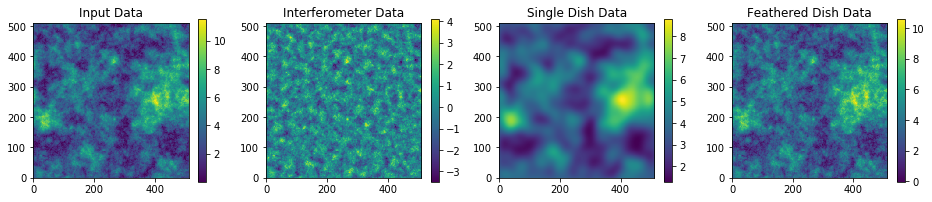

In [71]:
pl.figure(figsize=(16,3))
pl.subplot(1,4,1)
pl.imshow(input_hdu.data); pl.colorbar()
pl.title("Input Data")
pl.subplot(1,4,2)
pl.imshow(intf_hdu.data); pl.colorbar()
pl.title("Interferometer Data")
pl.subplot(1,4,3)
pl.imshow(sd_hdu.data); pl.colorbar()
pl.title("Single Dish Data")
pl.subplot(1,4,4)
pl.imshow(feathered_hdu.data); pl.colorbar()
pl.title("Feathered Dish Data")

What happens if we scale up the interferometric data?  Note that this is *NOT* normalized, so the total flux is not conserved.

In [72]:
feathered_hdu_2x = feather_simple(hires=intf_hdu, lores=sd_hdu, return_hdu=True, highresscalefactor=2)
feathered_hdu_10x = feather_simple(hires=intf_hdu, lores=sd_hdu, return_hdu=True, highresscalefactor=10)

INFO: Low-res FWHM: 0.009166666666666667 deg [uvcombine.uvcombine]
INFO: Converting data from MJy / sr to MJy / sr [uvcombine.uvcombine]
INFO: Low-res FWHM: 0.009166666666666667 deg [uvcombine.uvcombine]
INFO: Converting data from MJy / sr to MJy / sr [uvcombine.uvcombine]


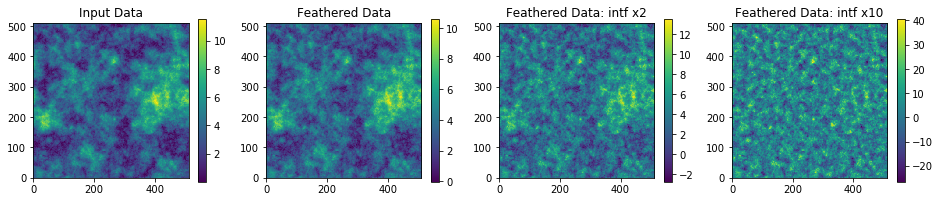

In [74]:
pl.figure(figsize=(16,3))
pl.subplot(1,4,1)
pl.imshow(input_hdu.data); pl.colorbar()
pl.title("Input Data")
pl.subplot(1,4,2)
pl.imshow(feathered_hdu.data); pl.colorbar()
pl.title("Feathered Data")
pl.subplot(1,4,3)
pl.imshow(feathered_hdu_2x.data); pl.colorbar()
pl.title("Feathered Data: intf x2")
pl.subplot(1,4,4)
pl.imshow(feathered_hdu_10x.data); pl.colorbar()
pl.title("Feathered Data: intf x10")